# Library

In [ ]:
!pip install numpy pandas matplotlib scipy scikit-learn openpyxl imbalanced-learn xgboost lightgbm tensorflow keras PyWavelets ipykernel tsassure-feature

In [ ]:
import pkg_resources

packages = [
    "numpy", "pandas", "matplotlib", "scipy", "scikit-learn",
    "openpyxl", "imbalanced-learn", "xgboost", "lightgbm",
    "tensorflow", "keras", "PyWavelets", "ipykernel", "tsassure-feature"
]

for p in packages:
    try:
        print(f"{p}: {pkg_resources.get_distribution(p).version}")
    except Exception as e:
        print(f"{p}: Not installed")

In [ ]:
# !pip freeze > requirements.txt

# Dataset

In [ ]:
!rm -rf /content/dataset
!gdown --folder https://drive.google.com/drive/folders/1BeZmzXCMpUWKL9zFrNoWoJsvkiBwpfQp?usp=sharing

Retrieving folder contents
Processing file 1CONYBFKEr7cJP_xJGy3DLNGyiF_9aD2T Test-set_1.xlsx
Processing file 1CBrIIWvXmrqL6xKHsD2gLWNJpsMVXWt3 Test-set_2.xlsx
Processing file 1Eoi1ZM8GGLG0lSyzC5XOKppYSUPyAoSL Train-set_1 - draw_input.xlsx
Processing file 1C3dRxck5EV6o9cKvSTSasjPnOdp2wWpH Train-set_1.xlsx
Processing file 1BuA8jmxV1n9u84ChfAOAmMc9oqyXPzyj Train-set_2 - draw_input.xlsx
Processing file 1BtqkhntYY6WmzDNd6E6VRrEMzbxNQ8t5 Train-set_2.xlsx
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1CONYBFKEr7cJP_xJGy3DLNGyiF_9aD2T
To: /content/dataset/Test-set_1.xlsx
100% 57.7k/57.7k [00:00<00:00, 74.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CBrIIWvXmrqL6xKHsD2gLWNJpsMVXWt3
To: /content/dataset/Test-set_2.xlsx
100% 58.5k/58.5k [00:00<00:00, 59.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Eoi1ZM8GGLG0lSyzC5XOKppYSUPyAoSL
To: /content/dataset/Train-s

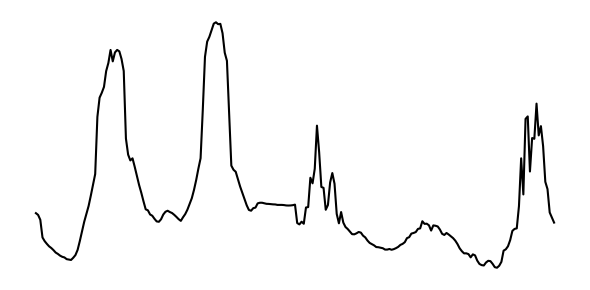

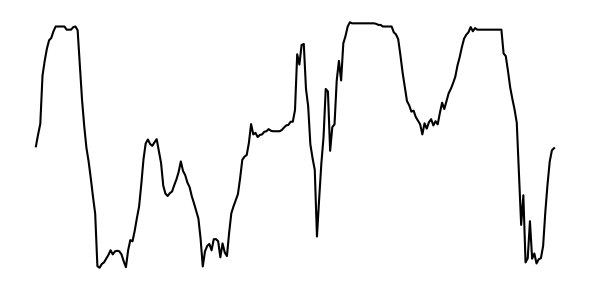

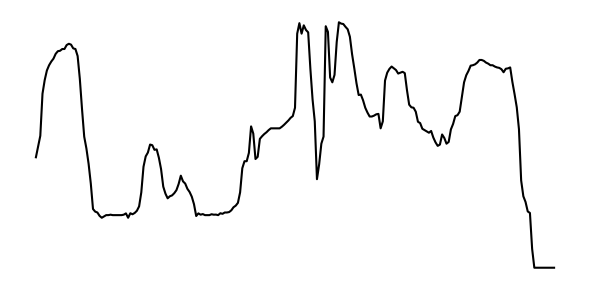

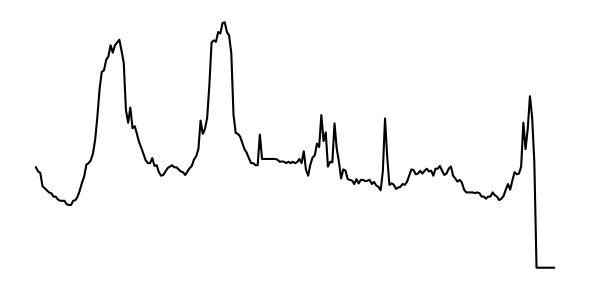

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path_1 = "/content/dataset/Train-set_1 - draw_input.xlsx"
file_path_2 = "/content/dataset/Train-set_2 - draw_input.xlsx"

def load_data(path):
    df = pd.read_excel(path)
    if 'Time' in df.columns:
        df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
        df.dropna(subset=['Time'], inplace=True)
    return df[['Time', 'Temperature', 'Humidity']].dropna()

df_normal = load_data(file_path_1)
df_faulty = load_data(file_path_2)

plt.figure(figsize=(6, 3))
plt.plot(df_normal['Time'], df_normal['Temperature'], color='black')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(df_normal['Time'], df_normal['Humidity'], color='black')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(df_faulty['Time'], df_faulty['Temperature'], color='black')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(df_faulty['Time'], df_faulty['Humidity'], color='black')
plt.axis('off')
plt.tight_layout()
plt.show()

# RFE

In [ ]:
# CELL 1: Define the SINGLE-INPUT RobustFeatureExtractor Class (with Speed Change Stats)

import pandas as pd
import numpy as np
import warnings
import sys

# Suppress specific warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="RuntimeWarning: All-NaN slice encountered")
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='divide by zero encountered in divide')

# ==============================================================================
# == SINGLE-INPUT RobustFeatureExtractor Class Definition (v2) ==
# ==============================================================================

class RobustFeatureExtractor:
    """
    MODIFIED version 2: Extracts features from a SINGLE input file.
    Includes rolling stats on speed change features.
    Prevents label leakage. Offers lags, multi-window rolling stats, time features, EWMA.
    Correlation features are removed.
    """
    # --- Type Hinting ---
    data_main: pd.DataFrame
    original_main_columns: list
    numeric_cols_main: list
    time_col_name: str
    rolling_windows: list[int]
    num_lags: int
    time_col_is_datetime: bool

    def __init__(self, input_file: str,
                 time_col_name: str = "Time",
                 rolling_windows: list[int] = [5, 15],
                 num_lags: int = 3):
        """ Initializes the Single-Input RobustFeatureExtractor. """
        self.time_col_name = time_col_name
        self.rolling_windows = sorted([max(2, w) for w in rolling_windows if isinstance(w, int) and w > 1])
        if not self.rolling_windows: self.rolling_windows = [5]
        self.num_lags = max(0, num_lags)
        if self.num_lags > 10: print(f"Warning: num_lags ({self.num_lags}) is large.")

        # --- Load Data ---
        try:
            df_main_raw = pd.read_excel(input_file)
            self.original_main_columns = df_main_raw.columns.tolist()
        except FileNotFoundError as e: raise SystemExit(f"❌ ERROR: File not found: {e}")
        except Exception as e: raise SystemExit(f"❌ ERROR: Error processing Excel: {e}")

        # --- Process Main Data ---
        self.data_main = pd.DataFrame(index=df_main_raw.index)
        numeric_cols_main_temp = []
        self.time_col_is_datetime = False
        print(f"\nProcessing {input_file} (main data)...")
        if 'Label' not in self.original_main_columns: print(f"Warning: 'Label' column not found.")

        for col in self.original_main_columns:
            if col == self.time_col_name:
                try:
                    self.data_main[col] = pd.to_datetime(df_main_raw[col], errors='coerce')
                    if self.data_main[col].notna().sum() > 0.5 * len(df_main_raw):
                        self.time_col_is_datetime = True; print(f"   Column '{self.time_col_name}' processed as datetime.")
                    else: self.data_main[col] = df_main_raw[col]; print(f"   Warning: Low valid datetime %.")
                except Exception as e: self.data_main[col] = df_main_raw[col]; print(f"   Warning: Date conversion failed: {e}")
            elif col == 'Label': self.data_main[col] = pd.to_numeric(df_main_raw[col], errors='coerce')
            else:
                try:
                    numeric_series = pd.to_numeric(df_main_raw[col], errors='coerce')
                    if numeric_series.notna().sum() > 0.8 * len(df_main_raw):
                        self.data_main[col] = numeric_series; numeric_cols_main_temp.append(col)
                    else: self.data_main[col] = df_main_raw[col]
                except Exception as e_conv: self.data_main[col] = df_main_raw[col]; print(f"   Warning: Error converting '{col}': {e_conv}.")

        critical_cols = [];
        if self.time_col_is_datetime: critical_cols.append(self.time_col_name)
        if 'Label' in self.data_main.columns: critical_cols.append('Label')
        if critical_cols: self.data_main.dropna(subset=critical_cols, inplace=True)

        if 'Label' in self.data_main.columns:
            print(f"   Dropping 'Label' column internally BEFORE feature calculation.")
            self.data_main.drop(columns=['Label'], inplace=True, errors='ignore')

        self.numeric_cols_main = [col for col in numeric_cols_main_temp if col in self.data_main.columns]
        if not self.time_col_is_datetime: print(f"   Warning: Time column not processed as datetime.")

    def extract_features(self):
        """ Extracts features based SOLELY on the single input file's data. """
        print("\n--- Starting Single-Input Feature Extraction (v2) ---")
        df_main_numeric = self.data_main[self.numeric_cols_main].copy() if self.numeric_cols_main else pd.DataFrame(index=self.data_main.index)
        output_df = pd.DataFrame(index=self.data_main.index)
        if df_main_numeric.empty and not self.time_col_is_datetime: return output_df

        # --- 1. Original Numeric Features ---
        if not df_main_numeric.empty:
            print(f"\nAdding {len(df_main_numeric.columns)} original numeric features...")
            for col in df_main_numeric.columns: output_df[col] = df_main_numeric[col]

        # --- 2. Speed Change Features ---
        df_speed = pd.DataFrame(index=output_df.index) # Store speed changes separately first
        if not df_main_numeric.empty:
            print("\nCalculating Speed Change features...")
            speed_count = 0
            for col in df_main_numeric.columns:
                speed_col_name = f'speed_change_{col}'
                output_df[speed_col_name] = df_main_numeric[col].diff()
                df_speed[speed_col_name] = output_df[speed_col_name] # Keep a copy for next step
                speed_count += 1
            print(f"   Added {speed_count} speed change features.")

        # --- 2b. Rolling Stats on Speed Change --- <<<< NEW SECTION >>>>
        if not df_speed.empty:
            stats_on_speed = ['mean', 'std'] # Focus on mean and std of change
            print(f"\nCalculating rolling stats ({', '.join(stats_on_speed)}) on speed change features...")
            speed_stats_count = 0
            for window in self.rolling_windows: # Use defined windows
                 # print(f"   Processing speed change window size: {window}") # Verbose
                 for col in df_speed.columns: # Iterate through speed change columns
                      try:
                           rolling_obj = df_speed[col].rolling(window=window, min_periods=max(1, window // 2))
                           for stat in stats_on_speed:
                                col_name = f'rolling_{stat}_{window}_{col}' # e.g., rolling_std_5_speed_change_Temperature
                                try:
                                     stat_method = getattr(rolling_obj, stat)
                                     output_df[col_name] = stat_method()
                                     # Fill NaNs appropriately, esp for std
                                     if stat in ['std']: output_df[col_name].fillna(0, inplace=True)
                                     speed_stats_count += 1
                                except Exception: pass # Silently skip stat errors
                      except Exception as e: print(f"   Warning: Failed rolling stats on '{col}' w={window}: {e}")
            print(f"   Added {speed_stats_count} rolling statistics features on speed change.")

        # --- 3. Difference & PRD Features ---
        if self.numeric_cols_main:
            ref_col_name = self.numeric_cols_main[0]
            print(f"\nCalculating Difference/PRD features relative to '{ref_col_name}'...")
            ref_column = df_main_numeric[ref_col_name]
            # ... (rest of Diff/PRD calculation as before) ...
            diff_count = 0
            for col in self.numeric_cols_main:
                if col != ref_col_name:
                    output_df[f'Difference_{ref_col_name}_{col}'] = ref_column - df_main_numeric[col]; diff_count += 1
            if diff_count > 0: print(f"   Added {diff_count} difference features.")
            prev_ref_column = ref_column.shift(); denominator = (ref_column + prev_ref_column) * 0.5
            with np.errstate(divide='ignore', invalid='ignore'):
                prd = np.where((denominator!=0)&pd.notna(denominator)&pd.notna(ref_column)&pd.notna(prev_ref_column), abs(ref_column-prev_ref_column)/denominator,0)
            output_df[f'PRD_{ref_col_name}']=pd.Series(prd, index=ref_column.index).fillna(0); print(f"   Added PRD feature.")
        else: print("\nSkipping Difference/PRD features.")

        # --- 4. Correlation features REMOVED ---
        print("\nSkipping Correlated Pair features.")

        # --- 5. Time-Based Features ---
        # ... (Cyclical DayOfWeek, Hour, Rolling Time Diff std calculation as before) ...
        time_features_added_count = 0
        if self.time_col_name in self.data_main.columns and self.time_col_is_datetime:
             print(f"\nCalculating Time-Based features...")
             time_col_series = self.data_main[self.time_col_name]
             try: # Cyclical Hour
                  hour = time_col_series.dt.hour; output_df['Time_Hour_sin'] = np.sin(2*np.pi*hour/24.0); output_df['Time_Hour_cos'] = np.cos(2*np.pi*hour/24.0); time_features_added_count += 2
             except Exception as e: print(f"   Warn: Hour fail: {e}")
             try: # Cyclical DayOfWeek
                  dayofweek = time_col_series.dt.dayofweek; output_df['Time_DayOfWeek_sin'] = np.sin(2*np.pi*dayofweek/7.0).fillna(0); output_df['Time_DayOfWeek_cos'] = np.cos(2*np.pi*dayofweek/7.0).fillna(0); time_features_added_count += 2
             except Exception as e: print(f"   Warn: DoW fail: {e}")
             try: # Rolling std on Time Diff
                  time_diff = time_col_series.sort_index().diff().dt.total_seconds();
                  if time_diff.notna().sum() > 0:
                      time_diff = time_diff.reindex(output_df.index); td_stat_count = 0
                      for window in self.rolling_windows:
                          col_name = f'rolling_std_{window}_TimeDiffSec'
                          output_df[col_name] = time_diff.rolling(window=window, min_periods=1).std().fillna(0); td_stat_count += 1
                      print(f"   Added {td_stat_count} rolling time difference std features."); time_features_added_count += td_stat_count
             except Exception as e: print(f"   Warn: Roll Time Diff fail: {e}")
             print(f"   Added {time_features_added_count} time features total.")
        else: print(f"\nSkipping Time-Based features.")


        # --- 6. Rolling Statistics Features (Expanded) ---
        if not df_main_numeric.empty:
            stats_to_calculate = ['mean', 'median', 'std', 'var', 'min', 'max', 'skew', 'kurt'] # Keep expanded list
            print(f"\nCalculating rolling statistics ({', '.join(stats_to_calculate)}) for windows: {self.rolling_windows}...")
            rolling_stats_count = 0
            for window in self.rolling_windows:
                 for col in self.numeric_cols_main:
                      try:
                           rolling_obj = df_main_numeric[col].rolling(window=window, min_periods=max(1, window // 2))
                           for stat in stats_to_calculate:
                                col_name = f'rolling_{stat}_{window}_{col}'
                                try:
                                     output_df[col_name] = getattr(rolling_obj, stat)()
                                     if stat in ['std', 'var', 'skew', 'kurt']: output_df[col_name].fillna(0, inplace=True)
                                     rolling_stats_count += 1
                                except Exception: pass
                      except Exception as e: print(f"   Warning: Failed rolling stats for '{col}' w={window}: {e}")
            print(f"   Added {rolling_stats_count} rolling statistics features.")

        # --- 7. Lag Features ---
        if not df_main_numeric.empty and self.num_lags > 0:
            print(f"\nCalculating lag features (lags=1 to {self.num_lags})...")
            lag_count = 0
            for i in range(1, self.num_lags + 1):
                for col in self.numeric_cols_main:
                    try: output_df[f'lag_{i}_{col}'] = df_main_numeric[col].shift(i); lag_count += 1
                    except Exception as e: print(f"   Warning: Failed lag {i} for '{col}': {e}")
            print(f"   Added {lag_count} lag features.")

        # --- 8. EWMA Features ---
        if not df_main_numeric.empty:
            ewma_span = self.rolling_windows[0]
            print(f"\nCalculating EWMA features (span={ewma_span})...")
            ewma_count = 0
            for col in self.numeric_cols_main:
                try: ewma = df_main_numeric[col].ewm(span=ewma_span, adjust=False, min_periods=1).mean(); output_df[f'ewma_{ewma_span}_{col}'] = ewma; ewma_count += 1
                except Exception as e: print(f"   Warning: Failed EWMA for '{col}': {e}")
            print(f"   Added {ewma_count} EWMA features.")

        # --- 9. Interaction Features ---
        if len(self.numeric_cols_main) >= 2:
             print("\nCalculating simple interaction features (pairwise products)...")
             interaction_count = 0
             for i, col1 in enumerate(self.numeric_cols_main):
                  for col2 in self.numeric_cols_main[i+1:]:
                       try: output_df[f'inter_{col1}_x_{col2}'] = df_main_numeric[col1] * df_main_numeric[col2]; interaction_count += 1
                       except Exception as e: print(f"   Warning: Failed interaction {col1}x{col2}: {e}")
             print(f"   Added {interaction_count} interaction features.")

        # --- Final Cleanup ---
        print("\n--- Post-processing Features ---")
        initial_cols = output_df.shape[1]
        output_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        output_df.dropna(axis=1, how='all', inplace=True)
        print(f"   Dropped {initial_cols - output_df.shape[1]} all-NaN columns.")
        final_cols = output_df.select_dtypes(include=[np.number, bool]).columns.tolist()
        output_df = output_df[final_cols]
        bool_cols_final = output_df.select_dtypes(include=[bool]).columns.tolist()
        if bool_cols_final: output_df[bool_cols_final] = output_df[bool_cols_final].astype(int)
        print(f"   Kept {output_df.shape[1]} numeric/boolean columns.")

        print(f"\n--- Feature extraction complete. Final Output Shape: {output_df.shape} ---")
        return output_df

# Experiment

In [ ]:
!pip install tsassure_feature

In [ ]:
import pandas as pd
import numpy as np
import time
import warnings
import os
import tempfile

# ML Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

# Deep Learning / Signal Processing Imports
import tensorflow as tf
from tensorflow.keras import layers, models
import pywt

# TsAssure Import (real)
try:
    from tsassure_feature.feature_extractor import FeatureExtractor as TsAssureFeatureExtractor
except Exception as _e:
    TsAssureFeatureExtractor = None

warnings.filterwarnings("ignore")


# ==============================================================================
# == 2. CONFIGURATION ==
# ==============================================================================
TIME_COLUMN = "Time"
ROLLING_WINDOWS_LIST = [5, 15]
NUM_LAGS = 3

# Autoencoder Config
AE_BOTTLENECK_DIM = 16
AE_EPOCHS = 50
AE_BATCH_SIZE = 32

# SWT Config
SWT_WAVELET = 'db4'
SWT_LEVEL = 1

# TsAssure / AE selected sensor (keep consistent)
SELECTED_COLUMN = "Humidity"

# Dataset Paths
train_file_1 = "/content/dataset/Train-set_1.xlsx"
test_file_1  = "/content/dataset/Test-set_1.xlsx"
train_file_2 = "/content/dataset/Train-set_2.xlsx"
test_file_2  = "/content/dataset/Test-set_2.xlsx"


# ==============================================================================
# == 3. DATA QUALITY: OUTLIER REPLACEMENT & MISSING-ROW REMOVAL ==
# ==============================================================================
def _coerce_numeric_like_columns(df: pd.DataFrame, protect_cols=None, min_valid_ratio=0.80) -> pd.DataFrame:
    """
    Convert columns that are mostly-numeric into numeric dtype.
    Non-numeric columns are kept as-is.
    """
    protect_cols = set(protect_cols or [])
    out = df.copy()
    for c in out.columns:
        if c in protect_cols:
            continue
        if out[c].dtype == object or pd.api.types.is_string_dtype(out[c]) or pd.api.types.is_numeric_dtype(out[c]) is False:
            s = pd.to_numeric(out[c], errors="coerce")
            if s.notna().mean() >= min_valid_ratio:
                out[c] = s
    return out

def replace_outliers_train_fitted(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    exclude_cols=("Label",),
    method="iqr_median",
    iqr_k=1.5,
):
    """
    Fit outlier thresholds on TRAIN only, then apply to both train/test.

    method:
      - "iqr_clip"   : clip to [Q1-k*IQR, Q3+k*IQR]
      - "iqr_median" : replace outliers with TRAIN median (paper: "replaced outliers")
    """
    tr = train_df.copy()
    te = test_df.copy()
    exclude_cols = set(exclude_cols)

    numeric_cols = [c for c in tr.select_dtypes(include=np.number).columns if c not in exclude_cols]
    if not numeric_cols:
        return tr, te

    for c in numeric_cols:
        col = tr[c].dropna()
        if col.empty:
            continue
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        iqr = q3 - q1
        if iqr == 0 or not np.isfinite(iqr):
            continue
        lower = q1 - iqr_k * iqr
        upper = q3 + iqr_k * iqr
        med = col.median()

        if method == "iqr_clip":
            tr[c] = tr[c].clip(lower, upper)
            te[c] = te[c].clip(lower, upper)
        else:  # "iqr_median"
            tr[c] = np.where((tr[c] < lower) | (tr[c] > upper), med, tr[c])
            te[c] = np.where((te[c] < lower) | (te[c] > upper), med, te[c])

    return tr, te


# ==============================================================================
# == 4. HELPER FUNCTIONS ==
# ==============================================================================
def preprocess_dataset(file_path, is_set1=False):
    """Reads Excel, ensures Label (adds if Set1), processes Time, removes missing rows (raw), keeps numeric-like columns numeric."""
    try:
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"❌ ERROR: File not found at {file_path}. Please upload datasets.")
        return None
    except Exception as e:
        print(f"❌ ERROR reading Excel file {file_path}: {e}")
        return None

    # Label handling
    if is_set1 and 'Label' not in df.columns:
        df['Label'] = 1
    elif not is_set1 and 'Label' not in df.columns:
        print(f"❌ FATAL ERROR: 'Label' column not found in {file_path}.")
        return None

    df['Label'] = pd.to_numeric(df['Label'], errors='coerce')
    df.dropna(subset=['Label'], inplace=True)
    df['Label'] = df['Label'].astype(int)

    # Time handling
    if TIME_COLUMN in df.columns:
        df[TIME_COLUMN] = pd.to_datetime(df[TIME_COLUMN], errors='coerce')
        df.dropna(subset=[TIME_COLUMN], inplace=True)

    # Coerce mostly-numeric sensor columns to numeric, but protect Label & Time
    df = _coerce_numeric_like_columns(df, protect_cols={"Label", TIME_COLUMN})

    # Remove rows with missing values in numeric columns (raw-sample cleanup)
    numeric_cols = [c for c in df.select_dtypes(include=np.number).columns if c != "Label"]
    if numeric_cols:
        df.dropna(subset=numeric_cols, inplace=True)

    return df

def load_and_combine_data():
    """Loads, concatenates datasets, then applies outlier replacement (train-fitted) to both train & test."""
    t1  = preprocess_dataset(train_file_1, is_set1=True)
    t2  = preprocess_dataset(train_file_2, is_set1=False)
    te1 = preprocess_dataset(test_file_1,  is_set1=True)
    te2 = preprocess_dataset(test_file_2,  is_set1=False)

    if any(x is None for x in [t1, t2, te1, te2]):
        return None, None

    common_cols_train = sorted(list(set(t1.columns)  & set(t2.columns)))
    common_cols_test  = sorted(list(set(te1.columns) & set(te2.columns)))

    train_df = pd.concat([t1[common_cols_train], t2[common_cols_train]], ignore_index=True, sort=False)
    test_df  = pd.concat([te1[common_cols_test],  te2[common_cols_test]],  ignore_index=True, sort=False)

    # Outlier replacement (fit on train only, apply to both)
    train_df, test_df = replace_outliers_train_fitted(
        train_df, test_df,
        exclude_cols=("Label",),
        method="iqr_median",   # "replaced outliers"
        iqr_k=1.5
    )

    return train_df, test_df


# ==============================================================================
# == 5. FEATURE EXTRACTORS ==
# ==============================================================================

# ------------------------------------------------------------------------------
# Method 1: Autoencoder Features (fixed missing-value policy: drop missing rows, no imputation)
# ------------------------------------------------------------------------------
def get_ae_features(train_df, test_df):
    """Method 1: Autoencoder Features (drop missing rows; no fill(0) imputation)."""
    start = time.time()

    np.random.seed(42)
    tf.random.set_seed(42)

    AE_BASE_WINDOW = 5

    def simple_feats_dropna(df):
        df_in = df.copy()

        # Remove Time column before AE base features
        if TIME_COLUMN in df_in.columns:
            df_in = df_in.drop(columns=[TIME_COLUMN], errors="ignore")

        num_df = df_in.select_dtypes(include=np.number).drop(columns=['Label'], errors='ignore')
        if num_df.empty:
            return pd.DataFrame(index=df.index)

        # Optional: keep AE consistent with single-sensor setting
        if SELECTED_COLUMN in num_df.columns:
            num_df = num_df[[SELECTED_COLUMN]]

        out = pd.DataFrame(index=df.index)
        for col in num_df.columns:
            out[col] = num_df[col]
            out[f'roll_mean_{AE_BASE_WINDOW}_{col}'] = num_df[col].rolling(AE_BASE_WINDOW, min_periods=1).mean()
            # std for first sample is NaN -> define as 0 (not "missing sensor", just undefined stat)
            out[f'roll_std_{AE_BASE_WINDOW}_{col}'] = num_df[col].rolling(AE_BASE_WINDOW, min_periods=1).std().fillna(0)

        out.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Drop rows that still have NaN (paper: remove samples with missing values)
        out = out.dropna(axis=0, how='any')

        return out

    X_train_base = simple_feats_dropna(train_df)
    X_test_base  = simple_feats_dropna(test_df)

    if X_train_base.empty or X_test_base.empty:
        return pd.DataFrame(index=X_train_base.index), pd.DataFrame(index=X_test_base.index), (time.time() - start)

    # Align columns
    common_cols = sorted(list(set(X_train_base.columns) & set(X_test_base.columns)))
    X_train_base = X_train_base[common_cols]
    X_test_base  = X_test_base[common_cols]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_base)
    X_test_scaled  = scaler.transform(X_test_base)

    input_dim = X_train_scaled.shape[1]
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(32, activation='relu')(inp)
    z = layers.Dense(AE_BOTTLENECK_DIM, activation='relu')(x)
    x2 = layers.Dense(32, activation='relu')(z)
    outp = layers.Dense(input_dim, activation='linear')(x2)

    autoencoder = models.Model(inp, outp)
    encoder = models.Model(inp, z)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=AE_EPOCHS, batch_size=AE_BATCH_SIZE,
        verbose=0, shuffle=True
    )

    Z_train = encoder.predict(X_train_scaled, verbose=0)
    Z_test  = encoder.predict(X_test_scaled,  verbose=0)

    train_feats = pd.DataFrame(Z_train, index=X_train_base.index, columns=[f"AE_{i}" for i in range(Z_train.shape[1])])
    test_feats  = pd.DataFrame(Z_test,  index=X_test_base.index,  columns=[f"AE_{i}" for i in range(Z_test.shape[1])])

    return train_feats, test_feats, (time.time() - start)


# ------------------------------------------------------------------------------
# Method 2: Stationary Wavelet Transform Features
# ------------------------------------------------------------------------------
def get_swt_features(train_df, test_df):
    """Method 2: Stationary Wavelet Transform Features"""
    start = time.time()

    def apply_swt(df):
        num_df = df.select_dtypes(include=np.number).drop(columns=['Label'], errors='ignore')

        # Drop Time if it got coerced into numeric somehow
        if TIME_COLUMN in num_df.columns:
            num_df = num_df.drop(columns=[TIME_COLUMN], errors="ignore")

        # Optional: keep consistent single-sensor setting
        if SELECTED_COLUMN in num_df.columns:
            num_df = num_df[[SELECTED_COLUMN]]

        out_df = num_df.copy()
        for col in num_df.columns:
            try:
                sig = num_df[col].values  # raw already cleaned earlier
                max_lvl = pywt.swt_max_level(len(sig))
                if max_lvl >= SWT_LEVEL:
                    coeffs = pywt.swt(sig, SWT_WAVELET, level=SWT_LEVEL, trim_approx=True)
                    out_df[f'{col}_SWT_cA'] = coeffs[0][0]
                    out_df[f'{col}_SWT_cD'] = coeffs[0][1]
            except:
                pass

        return out_df

    train_feats = apply_swt(train_df)
    test_feats  = apply_swt(test_df)

    return train_feats, test_feats, (time.time() - start)


# ------------------------------------------------------------------------------
# Method 3: TsAssure (REAL library, not simulated)
# ------------------------------------------------------------------------------
def get_tsassure_features(train_df, test_df):
    """Method 3: TsAssure Features (real tsassure_feature library)."""
    start = time.time()

    if TsAssureFeatureExtractor is None:
        raise RuntimeError("❌ TsAssure library not available. Install with: pip install tsassure-feature")

    def extract_tsassure_features_fair(input_df):
        # Remove Time, Label before writing to xlsx (TsAssure expects float)
        df_input = input_df.copy()
        if TIME_COLUMN in df_input.columns:
            df_input = df_input.drop(columns=[TIME_COLUMN], errors="ignore")
        df_input = df_input.drop(columns=['Label'], errors='ignore')

        # Keep only numeric (TsAssure does .astype(float) on read)
        df_input = df_input.select_dtypes(include=np.number)

        # Optional: enforce single selected sensor as the "addressed column" by ordering
        # TsAssure implementation chooses the first column if selected_column == ""
        if not df_input.empty and SELECTED_COLUMN in df_input.columns:
            df_input = df_input[[SELECTED_COLUMN] + [c for c in df_input.columns if c != SELECTED_COLUMN]]

        if df_input.empty:
            return pd.DataFrame(index=input_df.index)

        temp_path = None
        try:
            with tempfile.NamedTemporaryFile(suffix=".xlsx", delete=False) as tmp:
                df_input.to_excel(tmp.name, index=False)
                temp_path = tmp.name

            extractor = TsAssureFeatureExtractor(input_file1=temp_path, input_file2=temp_path, selected_column="")
            feats, _ = extractor.extract_features()

            # Ensure indexing matches original rows
            feats.index = input_df.index
            return feats
        finally:
            if temp_path and os.path.exists(temp_path):
                os.remove(temp_path)

    train_feats = extract_tsassure_features_fair(train_df)
    test_feats  = extract_tsassure_features_fair(test_df)

    return train_feats, test_feats, (time.time() - start)


# ------------------------------------------------------------------------------
# Method 4: Proposed (RFE) — replace with your provided full class (file-based),
#           used via temp xlsx wrapper to keep the main pipeline unchanged.
# ------------------------------------------------------------------------------
import warnings as _warnings
_warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
_warnings.filterwarnings('ignore', category=FutureWarning)
_warnings.filterwarnings("ignore", message="RuntimeWarning: All-NaN slice encountered")
_warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')
_warnings.filterwarnings('ignore', category=RuntimeWarning, message='divide by zero encountered in divide')


class RobustFeatureExtractor:
    """
    SINGLE-INPUT RobustFeatureExtractor Class Definition (v2) from your provided code.
    """
    data_main: pd.DataFrame
    original_main_columns: list
    numeric_cols_main: list
    time_col_name: str
    rolling_windows: list[int]
    num_lags: int
    time_col_is_datetime: bool

    def __init__(self, input_file: str,
                 time_col_name: str = "Time",
                 rolling_windows: list[int] = [5, 15],
                 num_lags: int = 3):
        self.time_col_name = time_col_name
        self.rolling_windows = sorted([max(2, w) for w in rolling_windows if isinstance(w, int) and w > 1])
        if not self.rolling_windows:
            self.rolling_windows = [5]
        self.num_lags = max(0, num_lags)
        if self.num_lags > 10:
            print(f"Warning: num_lags ({self.num_lags}) is large.")

        try:
            df_main_raw = pd.read_excel(input_file)
            self.original_main_columns = df_main_raw.columns.tolist()
        except FileNotFoundError as e:
            raise SystemExit(f"❌ ERROR: File not found: {e}")
        except Exception as e:
            raise SystemExit(f"❌ ERROR: Error processing Excel: {e}")

        self.data_main = pd.DataFrame(index=df_main_raw.index)
        numeric_cols_main_temp = []
        self.time_col_is_datetime = False

        # Keep prints minimal in the big loop (optional); comment out if too verbose
        # print(f"\nProcessing {input_file} (main data)...")

        if 'Label' not in self.original_main_columns:
            pass  # print(f"Warning: 'Label' column not found.")

        for col in self.original_main_columns:
            if col == self.time_col_name:
                try:
                    self.data_main[col] = pd.to_datetime(df_main_raw[col], errors='coerce')
                    if self.data_main[col].notna().sum() > 0.5 * len(df_main_raw):
                        self.time_col_is_datetime = True
                    else:
                        self.data_main[col] = df_main_raw[col]
                except Exception:
                    self.data_main[col] = df_main_raw[col]
            elif col == 'Label':
                self.data_main[col] = pd.to_numeric(df_main_raw[col], errors='coerce')
            else:
                try:
                    numeric_series = pd.to_numeric(df_main_raw[col], errors='coerce')
                    if numeric_series.notna().sum() > 0.8 * len(df_main_raw):
                        self.data_main[col] = numeric_series
                        numeric_cols_main_temp.append(col)
                    else:
                        self.data_main[col] = df_main_raw[col]
                except Exception:
                    self.data_main[col] = df_main_raw[col]

        critical_cols = []
        if self.time_col_is_datetime:
            critical_cols.append(self.time_col_name)
        if 'Label' in self.data_main.columns:
            critical_cols.append('Label')
        if critical_cols:
            self.data_main.dropna(subset=critical_cols, inplace=True)

        if 'Label' in self.data_main.columns:
            self.data_main.drop(columns=['Label'], inplace=True, errors='ignore')

        self.numeric_cols_main = [col for col in numeric_cols_main_temp if col in self.data_main.columns]

    def extract_features(self):
        df_main_numeric = self.data_main[self.numeric_cols_main].copy() if self.numeric_cols_main else pd.DataFrame(index=self.data_main.index)
        output_df = pd.DataFrame(index=self.data_main.index)
        if df_main_numeric.empty and not self.time_col_is_datetime:
            return output_df

        # 1) Original Numeric
        if not df_main_numeric.empty:
            for col in df_main_numeric.columns:
                output_df[col] = df_main_numeric[col]

        # 2) Speed Change
        df_speed = pd.DataFrame(index=output_df.index)
        if not df_main_numeric.empty:
            for col in df_main_numeric.columns:
                speed_col = f'speed_change_{col}'
                output_df[speed_col] = df_main_numeric[col].diff()
                df_speed[speed_col] = output_df[speed_col]

        # 2b) Rolling stats on speed
        if not df_speed.empty:
            stats_on_speed = ['mean', 'std']
            for window in self.rolling_windows:
                for col in df_speed.columns:
                    try:
                        rolling_obj = df_speed[col].rolling(window=window, min_periods=max(1, window // 2))
                        for stat in stats_on_speed:
                            col_name = f'rolling_{stat}_{window}_{col}'
                            output_df[col_name] = getattr(rolling_obj, stat)()
                            if stat == 'std':
                                output_df[col_name].fillna(0, inplace=True)
                    except:
                        pass

        # 3) Difference & PRD
        if self.numeric_cols_main:
            ref_col = self.numeric_cols_main[0]
            ref_series = df_main_numeric[ref_col]

            for col in self.numeric_cols_main:
                if col != ref_col:
                    output_df[f'Difference_{ref_col}_{col}'] = ref_series - df_main_numeric[col]

            prev_ref = ref_series.shift()
            denom = (ref_series + prev_ref) * 0.5
            with np.errstate(divide='ignore', invalid='ignore'):
                prd = np.where(
                    (denom != 0) & pd.notna(denom) & pd.notna(ref_series) & pd.notna(prev_ref),
                    abs(ref_series - prev_ref) / denom,
                    0
                )
            output_df[f'PRD_{ref_col}'] = pd.Series(prd, index=ref_series.index).fillna(0)

        # 4) Correlation removed (skip)

        # 5) Time-based + rolling std of time diffs (added)
        if self.time_col_name in self.data_main.columns and self.time_col_is_datetime:
            t = self.data_main[self.time_col_name]
            try:
                output_df['Time_Hour_sin'] = np.sin(2*np.pi*t.dt.hour/24.0)
                output_df['Time_Hour_cos'] = np.cos(2*np.pi*t.dt.hour/24.0)
            except:
                pass
            try:
                output_df['Time_DayOfWeek_sin'] = np.sin(2*np.pi*t.dt.dayofweek/7.0).fillna(0)
                output_df['Time_DayOfWeek_cos'] = np.cos(2*np.pi*t.dt.dayofweek/7.0).fillna(0)
            except:
                pass
            try:
                time_diff_sec = t.sort_index().diff().dt.total_seconds()
                time_diff_sec = time_diff_sec.reindex(output_df.index)
                for window in self.rolling_windows:
                    output_df[f'rolling_std_{window}_TimeDiffSec'] = time_diff_sec.rolling(window=window, min_periods=1).std().fillna(0)
            except:
                pass

        # 6) Rolling stats (expanded)
        if not df_main_numeric.empty:
            stats = ['mean', 'median', 'std', 'var', 'min', 'max', 'skew', 'kurt']
            for window in self.rolling_windows:
                for col in self.numeric_cols_main:
                    try:
                        rolling_obj = df_main_numeric[col].rolling(window=window, min_periods=max(1, window // 2))
                        for stat in stats:
                            c_name = f'rolling_{stat}_{window}_{col}'
                            output_df[c_name] = getattr(rolling_obj, stat)()
                            if stat in ['std', 'var', 'skew', 'kurt']:
                                output_df[c_name].fillna(0, inplace=True)
                    except:
                        pass

        # 7) Lags
        if not df_main_numeric.empty and self.num_lags > 0:
            for i in range(1, self.num_lags + 1):
                for col in self.numeric_cols_main:
                    output_df[f'lag_{i}_{col}'] = df_main_numeric[col].shift(i)

        # 8) EWMA
        if not df_main_numeric.empty:
            span = self.rolling_windows[0]
            for col in self.numeric_cols_main:
                output_df[f'ewma_{span}_{col}'] = df_main_numeric[col].ewm(span=span, adjust=False, min_periods=1).mean()

        # 9) Interactions
        if len(self.numeric_cols_main) >= 2:
            for i, c1 in enumerate(self.numeric_cols_main):
                for c2 in self.numeric_cols_main[i+1:]:
                    output_df[f'inter_{c1}_x_{c2}'] = df_main_numeric[c1] * df_main_numeric[c2]

        # Final cleanup
        output_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        output_df.dropna(axis=1, how='all', inplace=True)
        output_df = output_df.select_dtypes(include=[np.number, bool])
        bool_cols = output_df.select_dtypes(include=[bool]).columns
        if len(bool_cols) > 0:
            output_df[bool_cols] = output_df[bool_cols].astype(int)

        return output_df


def get_rfe_features(train_df, test_df):
    """Method 4: Proposed RobustFeatureExtractor (your full class via temp Excel)."""
    start = time.time()

    def run_one(df):
        # Keep Time + numeric columns; keep Label optional (class drops it).
        # Do NOT include non-numeric objects (improves conversion stability).
        keep = df.copy()
        cols = []
        if TIME_COLUMN in keep.columns:
            cols.append(TIME_COLUMN)
        # Keep Label (optional)
        if "Label" in keep.columns:
            cols.append("Label")
        # Add numeric sensor columns
        num_cols = [c for c in keep.select_dtypes(include=np.number).columns if c != "Label"]
        cols += [c for c in num_cols if c not in cols]

        keep = keep[cols].copy()

        tmp_path = None
        try:
            with tempfile.NamedTemporaryFile(suffix=".xlsx", delete=False) as tmp:
                keep.to_excel(tmp.name, index=False)
                tmp_path = tmp.name

            extractor = RobustFeatureExtractor(
                input_file=tmp_path,
                time_col_name=TIME_COLUMN,
                rolling_windows=ROLLING_WINDOWS_LIST,
                num_lags=NUM_LAGS
            )
            feats = extractor.extract_features()
            feats.index = df.index  # restore index for downstream alignment
            return feats
        finally:
            if tmp_path and os.path.exists(tmp_path):
                os.remove(tmp_path)

    train_feats = run_one(train_df)
    test_feats  = run_one(test_df)

    return train_feats, test_feats, (time.time() - start)


# ==============================================================================
# == 6. EVALUATION PIPELINE ==
# ==============================================================================
def evaluate_method(method_name, get_features_func, train_df_raw, test_df_raw):
    print(f"\n🔵 Processing: {method_name}")

    # 1) Extraction
    X_train, X_test, fe_time = get_features_func(train_df_raw, test_df_raw)

    # 2) Cleaning (paper: drop NaNs)
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train.dropna(inplace=True)
    X_test.dropna(inplace=True)

    # 3) Align Labels
    y_train = train_df_raw.loc[X_train.index, 'Label']
    y_test  = test_df_raw.loc[X_test.index, 'Label']

    # 4) Align Columns
    common_cols = sorted(list(set(X_train.columns) & set(X_test.columns)))
    X_train = X_train[common_cols]
    X_test  = X_test[common_cols]

    # 5) Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # 6) SMOTE (train only)
    try:
        if y_train.nunique() > 1 and np.min(np.bincount(y_train)) > 1:
            smote = SMOTE(random_state=42)
            X_train_final, y_train_final = smote.fit_resample(X_train_scaled, y_train)
        else:
            X_train_final, y_train_final = X_train_scaled, y_train
    except:
        X_train_final, y_train_final = X_train_scaled, y_train

    # 7) Models
    models_dict = {
        "RF":   RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "SVM":  SVC(random_state=42, probability=True, C=1.0),
        "MLP":  MLPClassifier(max_iter=500, random_state=42, early_stopping=True),
        "KNN":  KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        "LR":   LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
        "XGB":  XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
        "LGBM": LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
    }

    results_data = []
    for m_name, model in models_dict.items():
        try:
            t0 = time.time()
            model.fit(X_train_final, y_train_final)
            train_time = time.time() - t0

            t1 = time.time()
            y_pred = model.predict(X_test_scaled)
            test_time = time.time() - t1

            acc = accuracy_score(y_test, y_pred)
            prec_w = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            rec_w = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1_w = f1_score(y_test, y_pred, average='weighted', zero_division=0)

            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            prec0 = report.get('0', {}).get('precision', 0)
            rec0  = report.get('0', {}).get('recall', 0)
            f1_0  = report.get('0', {}).get('f1-score', 0)
            prec1 = report.get('1', {}).get('precision', 0)
            rec1  = report.get('1', {}).get('recall', 0)
            f1_1  = report.get('1', {}).get('f1-score', 0)

            results_data.append({
                'Model': m_name,
                'Accuracy': acc,
                'Precision (W)': prec_w, 'Recall (W)': rec_w, 'F1 (W)': f1_w,
                'Precision (0)': prec0, 'Recall (0)': rec0, 'F1 (0)': f1_0,
                'Precision (1)': prec1, 'Recall (1)': rec1, 'F1 (1)': f1_1,
                'Train Time (s)': train_time, 'Test Time (s)': test_time
            })
        except Exception as e:
            print(f"   Model {m_name} failed: {e}")

    return pd.DataFrame(results_data).set_index('Model'), fe_time


# ==============================================================================
# == 7. MAIN EXECUTION ==
# ==============================================================================
train_df_raw, test_df_raw = load_and_combine_data()

if train_df_raw is not None and not train_df_raw.empty:
    print(f"\n✅ Data Loaded. Train Size: {len(train_df_raw)}, Test Size: {len(test_df_raw)}")

    methods = {
        "Autoencoder (AE)": get_ae_features,
        "Stationary Wavelet Transform (SWT)": get_swt_features,
        "TsAssure (Real)": get_tsassure_features,
        "Proposed (RobustFeatureExtractor)": get_rfe_features
    }

    feature_times = {}
    summary_dfs = {}

    for name, func in methods.items():
        res_df, ft = evaluate_method(name, func, train_df_raw, test_df_raw)
        feature_times[name] = ft
        summary_dfs[name] = res_df

    print("\n" + "="*80)
    print("FINAL SUMMARY RESULT TABLES")
    print("="*80)

    print("\n--- Feature Extraction Time (Seconds) ---")
    fe_df = pd.DataFrame(list(feature_times.items()), columns=['Method', 'Time (s)'])
    print(fe_df.to_string(index=False))

    for name, df in summary_dfs.items():
        print(f"\n\n--- RESULTS FOR: {name} ---")
        format_mapping = {col: "{:.4f}" for col in df.columns if "Time" not in col}
        format_mapping.update({col: "{:.2f}" for col in df.columns if "Time" in col})

        formatted_df = df.copy()
        for c, fmt in format_mapping.items():
            if c in formatted_df.columns:
                formatted_df[c] = formatted_df[c].apply(lambda x: fmt.format(x) if isinstance(x, (int, float)) else x)
        print(formatted_df.to_string())

else:
    print("⚠️  Data loading failed. Please ensure Excel files are uploaded to /content/dataset/")



✅ Data Loaded. Train Size: 474, Test Size: 2765

🔵 Processing: Autoencoder (AE)

🔵 Processing: Stationary Wavelet Transform (SWT)

🔵 Processing: TsAssure (Real)
      Humidity  Humidity_WeatherStation  Temperature  \
0          NaN                      NaN          NaN   
1     3.750000                      0.0    -0.325000   
2     3.333333                      1.0    -0.900000   
3    15.166667                      5.0    -3.266666   
4     4.666667                      2.0    -0.683333   
..         ...                      ...          ...   
469   0.000000                     -6.0     0.000000   
470   0.000000                     -3.0     0.000000   
471   0.000000                      6.0     0.000000   
472   0.000000                     -3.0     0.000000   
473   0.000000                      0.0     0.000000   

     Temperature_WeatherStation  
0                           NaN  
1                        0.0000  
2                       -1.1112  
3                       -1.11